In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze
import torchattacks
from torch.utils.data import TensorDataset, DataLoader
from carla import Data
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import List

from carla import MLModel
from carla import Data
from carla.models.api import MLModel
from carla.recourse_methods.api import RecourseMethod
from carla.evaluation.distances import get_distances

import torch.nn as nn
from torch.nn.functional import normalize

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/f

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


# Unconstrained-- Fashion MNIST


## Growing Spheres


In [2]:
# Load Data, Serialized Model Objects, and Generated Counterfactuals

# Data
# Image preprocessing modules
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])

# Download data 
train_data = datasets.FashionMNIST(root = '.',
                              train = True,
                              download = True, 
                              transform=transform)
test_data = datasets.FashionMNIST(root = '.',
                             train = False, 
                             download = True, 
                             transform=transform)

features_train = np.zeros((12000, 32, 32))
label_train = np.zeros((12000,))
count = 0
for i in range(train_data.data.shape[0]):
    features, label = train_data.__getitem__(i)
    if label == 0 or label == 1:
        features_train[count] = features.detach().numpy()
        label_train[count] = label
        count += 1

features_train = np.asarray(features_train)
label_train = np.asarray(label_train)

features_test = np.zeros((2000, 32, 32))
label_test = np.zeros((2000,))
count = 0
for i in range(test_data.data.shape[0]):
    features, label = test_data.__getitem__(i)
    if label == 0 or label == 1:
        features_test[count] = features.detach().numpy()
        label_test[count] = label
        count += 1

features_test = np.asarray(features_test)
label_test = np.asarray(label_test)

BATCH_SIZE = 128 
# prepare the dataloader
train_dataset = TensorDataset(torch.flatten(torch.Tensor(features_train).float(), start_dim=1), torch.Tensor(label_train))
val_dataset = TensorDataset(torch.flatten(torch.Tensor(features_test).float(), start_dim=1), torch.Tensor(label_test))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)

feature_cols = []
for i in range(32):
    for j in range(32):
        feature_cols.append('pixel_{}_{}'.format(i, j))

features_train = torch.flatten(torch.Tensor(features_train).float(), start_dim=1).detach().numpy()
df = pd.DataFrame(features_train, columns=feature_cols)
df['Income_Greater_50k'] = label_train
df['Income_Greater_50k'] = df['Income_Greater_50k'].astype(int)
df.head()

SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features_train))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features_train)*0.8)]  # 80% data for training
val_index = random_index[int(len(features_train)*0.8):]


# generate the training data and validation data
train_data_df = df.iloc[train_index]
val_data_df = df.iloc[val_index]



# Custom data set implementations need to inherit from the Data interface
class IncomeDataset(Data):

    def __init__(self, data, train, val, feature_cols):
        # The data set can e.g. be loaded in the constructor
        self._dataset = data
        self._train = train
        self._val = val
        self.feature_cols = feature_cols

    # List of all categorical features
    @property
    def categorical(self):
        return []

    # List of all continuous features
    @property
    def continuous(self):
        return self.feature_cols

    # List of all immutable features which
    # should not be changed by the recourse method
    @property
    def immutables(self):
        return []

    # Feature name of the target column
    @property
    def target(self):
        return 'Income_Greater_50k'
    
    @property
    def df(self):
        return self._dataset
        pass

    @property
    def df_train(self):
        return self._train

    @property
    def df_test(self):
        return self._val

    def transform(self, df):
        new_vals = normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)

    def inverse_transform(self, df):
        new_vals = inverse_normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)
    
    def normalization(tensor, mean, std):
        return ((tensor - mean) / std).float()
    
    def inverse_normalization(x, mean, std):
        return (x*std)+mean
    
ds = IncomeDataset(df, train_data_df, val_data_df, feature_cols)



In [3]:
# Model Definition & Load

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=1024, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = output.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor):
    return normalize(tensor, p=2.0, dim = 0)

nat_model_state = torch.load('model_artifacts/naturally_trained_model_fashion.pt')
nat_model = my_net()
nat_model.load_state_dict(nat_model_state)

adv_model_state = torch.load('model_artifacts/adversarially_trained_model_fashion.pt')
adv_model = my_net()
adv_model.load_state_dict(adv_model_state)

# Custom black-box models need to inherit from
# the MLModel interface
class MyOwnModel(MLModel):
    def __init__(self, data, model, feature_cols):
        super().__init__(data)
        # The constructor can be used to load or build an
        # arbitrary black-box-model
        self._mymodel = model
        self.feature_cols = feature_cols

    # List of the feature order the ml model was trained on
    @property
    def feature_input_order(self):
        return self.feature_cols
    # The ML framework the model was trained on
    @property
    def backend(self):
        return "pytorch"

    # The black-box model object
    @property
    def raw_model(self):
        return self._mymodel

    # The predict function outputs
    # the continuous prediction of the model
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        return self._mymodel(x).max(1).indices

    # The predict_proba method outputs
    # the prediction as class probabilities
    def predict_proba(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        logits = self._mymodel(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().numpy()
    
nat_model_carla = MyOwnModel(ds, nat_model, feature_cols)
adv_model_carla = MyOwnModel(ds, adv_model, feature_cols)


In [4]:
# Load Generated Counterfactuals
factuals = ds.df[:500]
counterfactuals_1 = pd.read_csv('data_artifacts/fashion/gs_cfs_natural_model_fashion.csv').drop('Unnamed: 0', axis=1)
counterfactuals_2 = pd.read_csv('data_artifacts/fashion/gs_cfs_adv_model_fashion.csv').drop('Unnamed: 0', axis=1)


### Success Rate

In [5]:
print('Success Rate of Naturally Trained Model (Growing Spheres, Fashion): {}'.format(min(1, sum(counterfactuals_1['pixel_0_0'].notnull())/(factuals.shape[0]-sum(factuals['Income_Greater_50k']==1)))))
print('Success Rate of Adversarially Trained Model (Growing Spheres, Fashion): {}'.format(min(1, sum(counterfactuals_1['pixel_0_0'].notnull())/(factuals.shape[0]-sum(factuals['Income_Greater_50k']==1)))))


Success Rate of Naturally Trained Model (Growing Spheres, Fashion): 1
Success Rate of Adversarially Trained Model (Growing Spheres, Fashion): 1


### Distance From Original Point

In [6]:
def dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
            
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        distances.append(get_distances(row_copy, original)[0][dist_type])
    return distances

dist_1 = dist(ds, counterfactuals_1, nat_model_carla)
dist_2 = dist(ds, counterfactuals_2, adv_model_carla)


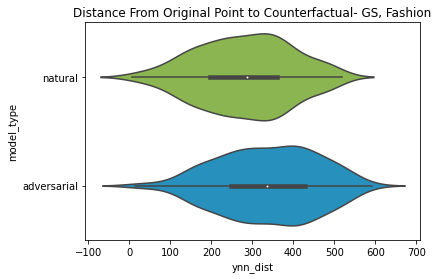

In [7]:
import seaborn as sns
thing = ['natural']*len([val for val in dist_1 if not pd.isnull(val)])+['adversarial']*len([val for val in dist_2 if not pd.isnull(val)])
df=pd.DataFrame(columns = ['ynn_dist', 'model_type'])
df['ynn_dist'] = [val for val in dist_1 if not pd.isnull(val)] + [val for val in dist_2 if not pd.isnull(val)]
df['model_type'] = thing
colors = ["#8DC63F", "#0F9AD6", "#013C5B", "#698795", "#000000"]
sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(x="ynn_dist", 
                    y="model_type", 
                    data=df).set(title='Distance From Original Point to Counterfactual- GS, Fashion')


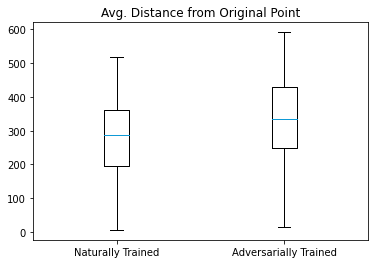

In [8]:
plt.figure()
plt.boxplot([[val for val in dist_1 if not pd.isnull(val)], [val for val in dist_2 if not pd.isnull(val)]])
plt.title('Avg. Distance from Original Point')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()



### Distance to Positive Manifold

In [9]:
def yNN_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    y: int = 1,
    dist_type: int =1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=y).fit(positive_class.values)

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
        
        knn = nbrs.kneighbors(factuals.df.iloc[i].values.reshape((1,-1)), 1, return_distance=False)[0]
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        neighbour = positive_class.iloc[knn[0]]
        neighbour = neighbour.drop(mlmodel.data.target)
        neighbour = neighbour.values.reshape((1, -1))
        distance_original_to_closest_pos = get_distances(original, neighbour)[0][dist_type]
        
        knn = nbrs.kneighbors(row.values.reshape((1, -1)), y, return_distance=False)[0]
        distances_local = 0
        
        for idx in knn:
            neighbour = positive_class.iloc[idx]
            neighbour = neighbour.drop(mlmodel.data.target)
            neighbour = neighbour.values.reshape((1, -1))
            row_copy = row.drop(mlmodel.data.target)
            row_copy = row_copy.values.reshape((1, -1))
            
            distances_local += get_distances(row_copy, neighbour)[0][dist_type]
        distances.append(((1 / y) * distances_local)/distance_original_to_closest_pos)
    return distances

def sphere_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    sphere_factor: float = 0.8,
    dist_type: int = 2,
)-> List[List[float]]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
        all_deltas = np.asarray(factuals.df.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        all_dists = np.sum(np.square(np.abs(all_deltas)), axis=1, dtype=np.float)
        all_euc_dist = np.sqrt(all_dists)
        radius = np.mean(all_euc_dist)*sphere_factor

        pos_deltas = np.asarray(positive_class.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        pos_dists = np.sum(np.square(np.abs(pos_deltas)), axis=1, dtype=np.float)
        pos_euc_dist = np.sqrt(pos_dists)
        relevant_neighbors = np.where(pos_euc_dist < radius)[0]
        #print(relevant_neighbors)
        if len(relevant_neighbors) == 0:
            distances.append(np.nan)
        else:
            relevant_distances = pos_euc_dist[relevant_neighbors]
            distances.append(np.mean(relevant_distances))
        
    return distances


In [10]:
ynn_1 = yNN_manifold(ds, counterfactuals_1, nat_model_carla)
ynn_2 = yNN_manifold(ds, counterfactuals_2, adv_model_carla)

sphere_1 = sphere_manifold(ds, counterfactuals_1, nat_model_carla)
sphere_2 = sphere_manifold(ds, counterfactuals_2, adv_model_carla)

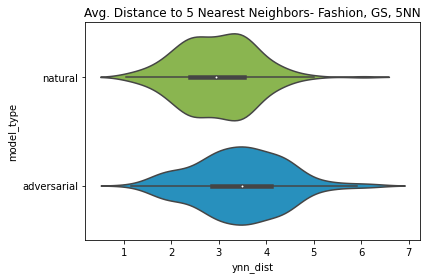

In [11]:
import seaborn as sns
thing = ['natural']*len([val for val in ynn_1 if not pd.isnull(val)])+['adversarial']*len([val for val in ynn_2 if not pd.isnull(val)])
df=pd.DataFrame(columns = ['ynn_dist', 'model_type'])
df['ynn_dist'] = [val for val in ynn_1 if not pd.isnull(val)] + [val for val in ynn_2 if not pd.isnull(val)]
df['model_type'] = thing
colors = ["#8DC63F", "#0F9AD6", "#013C5B", "#698795", "#000000"]
sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(x="ynn_dist", 
                    y="model_type", 
                    data=df).set(title='Avg. Distance to 5 Nearest Neighbors- Fashion, GS, 5NN')


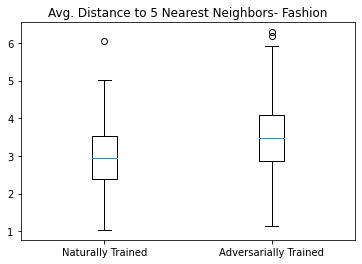

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([[val for val in ynn_1 if not pd.isnull(val)], [val for val in ynn_2 if not pd.isnull(val)]])
plt.title('Avg. Distance to 5 Nearest Neighbors- Fashion')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

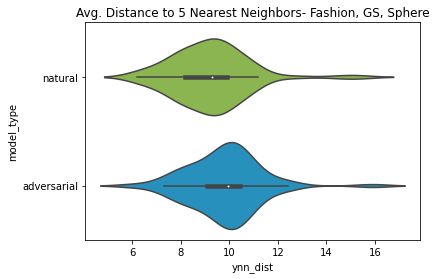

In [13]:
import seaborn as sns
thing = ['natural']*len([val for val in sphere_1 if not pd.isnull(val)])+['adversarial']*len([val for val in sphere_2 if not pd.isnull(val)])
df=pd.DataFrame(columns = ['ynn_dist', 'model_type'])
df['ynn_dist'] = [val for val in sphere_1 if not pd.isnull(val)] + [val for val in sphere_2 if not pd.isnull(val)]
df['model_type'] = thing
colors = ["#8DC63F", "#0F9AD6", "#013C5B", "#698795", "#000000"]
sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(x="ynn_dist", 
                    y="model_type", 
                    data=df).set(title='Avg. Distance to 5 Nearest Neighbors- Fashion, GS, Sphere')


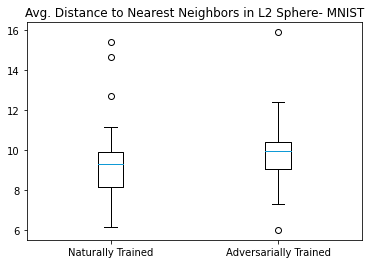

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([[val for val in sphere_1 if not pd.isnull(val)], [val for val in sphere_2 if not pd.isnull(val)]])
plt.title('Avg. Distance to Nearest Neighbors in L2 Sphere- MNIST')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

### Normalized Distance from Original Point

In [15]:
def norm_dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]
    
    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(positive_class.values)
    

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any() or factuals.df.iloc[i][mlmodel.data.target]==1:
            distances.append(np.nan)
            continue
        knn = nbrs.kneighbors(factuals.df.iloc[i].values.reshape((1,-1)), 1, return_distance=False)[0]
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        neighbour = positive_class.iloc[knn[0]]
        neighbour = neighbour.drop(mlmodel.data.target)
        neighbour = neighbour.values.reshape((1, -1))
        
        distance_original_to_closest_pos = get_distances(original, neighbour)[0][dist_type]
        
            
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        
        distance_cf_to_original = get_distances(row_copy, original)[0][dist_type]
        
        distances.append(distance_cf_to_original/distance_original_to_closest_pos)
    return distances

norm_dist_1 = norm_dist(ds, counterfactuals_1, nat_model_carla)
norm_dist_2 = norm_dist(ds, counterfactuals_2, adv_model_carla)

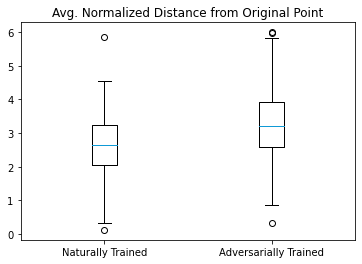

In [16]:
plt.figure()
plt.boxplot([[val for val in norm_dist_1 if not pd.isnull(val)], [val for val in norm_dist_2 if not pd.isnull(val)]])
plt.title('Avg. Normalized Distance from Original Point')
plt.xticks([1, 2], ['Naturally Trained', 'Adversarially Trained'])
plt.show()

### Plotting Normalized Distance From Original vs. Manifold Proximity

Text(0, 0.5, 'Proximity to Positive Manifold')

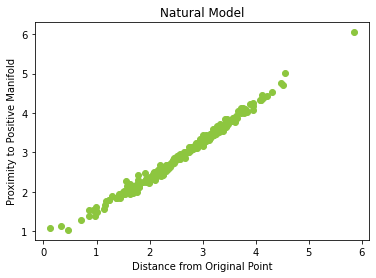

In [17]:
plt.scatter(norm_dist_1, ynn_1)
plt.title('Natural Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')


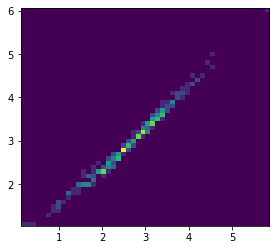

In [18]:
x = [val for val in norm_dist_1 if not pd.isnull(val)]
y = [val for val in ynn_1 if not pd.isnull(val)]
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

Text(0, 0.5, 'Proximity to Positive Manifold')

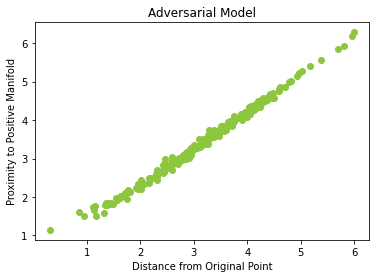

In [19]:
plt.scatter(norm_dist_2, ynn_2)
plt.title('Adversarial Model')
plt.xlabel('Distance from Original Point')
plt.ylabel('Proximity to Positive Manifold')


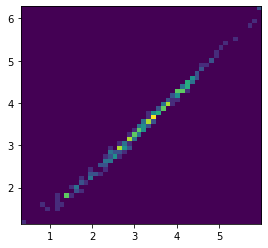

In [20]:
x = [val for val in norm_dist_2 if not pd.isnull(val)]
y = [val for val in ynn_2 if not pd.isnull(val)]
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

### Connectedness

In [21]:
def connectedness(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    mlmodel: MLModel,
    dist_type: int =1,
):#-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    crosses = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(positive_class.values)

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            crosses.append(np.nan)
            continue
        knn = nbrs.kneighbors(row.values.reshape((1, -1)), 1, return_distance=False)[0]
        cross = 0
        row = row.drop(mlmodel.data.target)
        for idx in knn:
            neighbour = positive_class.iloc[idx]
            neighbour = neighbour.drop(mlmodel.data.target)
            step = (neighbour-row)/100
            step_df = pd.DataFrame(columns = row.index, index = np.arange(100)).astype(neighbour.dtypes)
            for j in range(100):
                step_df.iloc[j] = (row+step*(j+1)).astype(np.float64)
            preds = []
            preds = mlmodel.predict_proba(step_df).argmax(1)
            for j, pred in enumerate(preds):
                if j < len(preds)-1:
                    if pred == 1 and preds[j+1] == 0:
                        cross += 1
        crosses.append(cross)
    return crosses

In [22]:
con_gs_1 = connectedness(ds, counterfactuals_1, nat_model_carla)
con_gs_2 = connectedness(ds, counterfactuals_2, adv_model_carla)


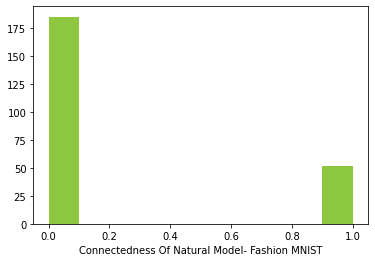

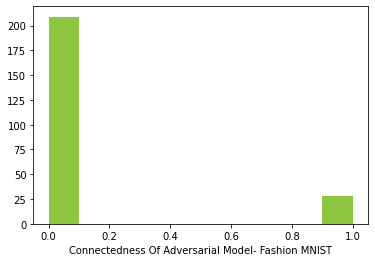

In [23]:
plt.figure()
plt.hist(con_gs_1)
plt.xlabel('Connectedness Of Natural Model- Fashion MNIST')
plt.show()

plt.figure()
plt.hist(con_gs_2)
plt.xlabel('Connectedness Of Adversarial Model- Fashion MNIST')
plt.show()

In [24]:
sum([1 if val == 0 else 0 for val in con_gs_1])

185

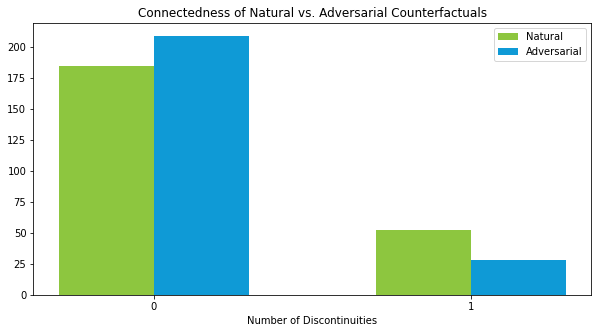

In [25]:
# Numbers of pairs of bars you want
N = 2

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (sum([1 if val == 0 else 0 for val in con_gs_1]), sum([1 if val == 1 else 0 for val in con_gs_1]))
# Specify the values of orange bars (height)
orange_bar = (sum([1 if val == 0 else 0 for val in con_gs_2]), sum([1 if val == 1 else 0 for val in con_gs_2]))

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Natural')
plt.bar(ind + width, orange_bar, width, label='Adversarial')

plt.xlabel('Number of Discontinuities')
plt.title('Connectedness of Natural vs. Adversarial Counterfactuals')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('0', '1'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

# Constrained-- Adult


## Growing Spheres

In [26]:
# Load Data and Generated Counterfactuals ()

### Success Rate

### Distance From Original Point

### Normalized Distance from Original Point

### Distance to Positive Manifold

### Continuity

## Actionable Recourse

### Success Rate

### Distance From Original Point

### Normalized Distance from Original Point

### Distance to Positive Manifold

### Continuity